## Imports

In [1]:
# utils
import os
import sys
from pathlib import Path

PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# viz
import matplotlib.pyplot as plt

# basics
import numpy as np
import pandas as pd

# metrics
from tqdm import tqdm

# metrics
from utils import config
from utils.reader import read_file_yaml
from utils.utils import get_last_modification_directory
import warnings

warnings.filterwarnings("ignore")

## Parameters

In [2]:
path_outputs = PROJECT_DIR / "outputs"
path_data_url = PROJECT_DIR / "data"
file_path_parameters = PROJECT_DIR / "conf" / "parameters.yml"
parameters = read_file_yaml(file_path_parameters)
path_results = PROJECT_DIR / parameters["results"]["filepath"]
path_results_url = PROJECT_DIR / parameters["results"]["filepath"]
ext_type = parameters["outputs"]["extension_type"]
ext_local_img = parameters["outputs"]["extension_local_img"]
ext_best_img = parameters["outputs"]["extension_best_img"]

n_random = np.sort(
    [int(i.replace("random_n", "")) for i in os.listdir(path_results_url) if ".placehold" not in i]
)
path_random = ["random_n" + str(i) for i in n_random]
path_results = [path_results_url / i for i in path_random]

_, path_random = get_last_modification_directory(path_results, path_random, parameters)

file_path_abi_diff = {
    i_name: {
        name: {
            _param: i / name / "params" / Path(_param + ext_type)
            for _param in ["abilities", "diff_disc"]
        }
        for name in config.file_names
    }
    for i, i_name in zip(path_results, path_random)
}

file_path_pij = {
    i_name: {
        name: {_param: i / name / "pij" / Path(_param + ext_type) for _param in ["pij_true", "pij_pred"]}
        for name in config.file_names
    }
    for i, i_name in zip(path_results, path_random)
}

## Read datasets

In [3]:
# params
data_params = {
    i_random: {
        j_name: {k_param: pd.read_csv(k_content, index_col=0) for k_param, k_content in j_content.items()}
        for j_name, j_content in i_content.items()
    }
    for i_random, i_content in file_path_abi_diff.items()
}

In [4]:
# pij
data_pij = {
    i_random: {
        j_name: {k_param: pd.read_csv(k_content, index_col=0) for k_param, k_content in j_content.items()}
        for j_name, j_content in i_content.items()
    }
    for i_random, i_content in file_path_pij.items()
}

## Plot

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 40/71 [00:34<00:27,  1.15it/s]


KeyboardInterrupt: 

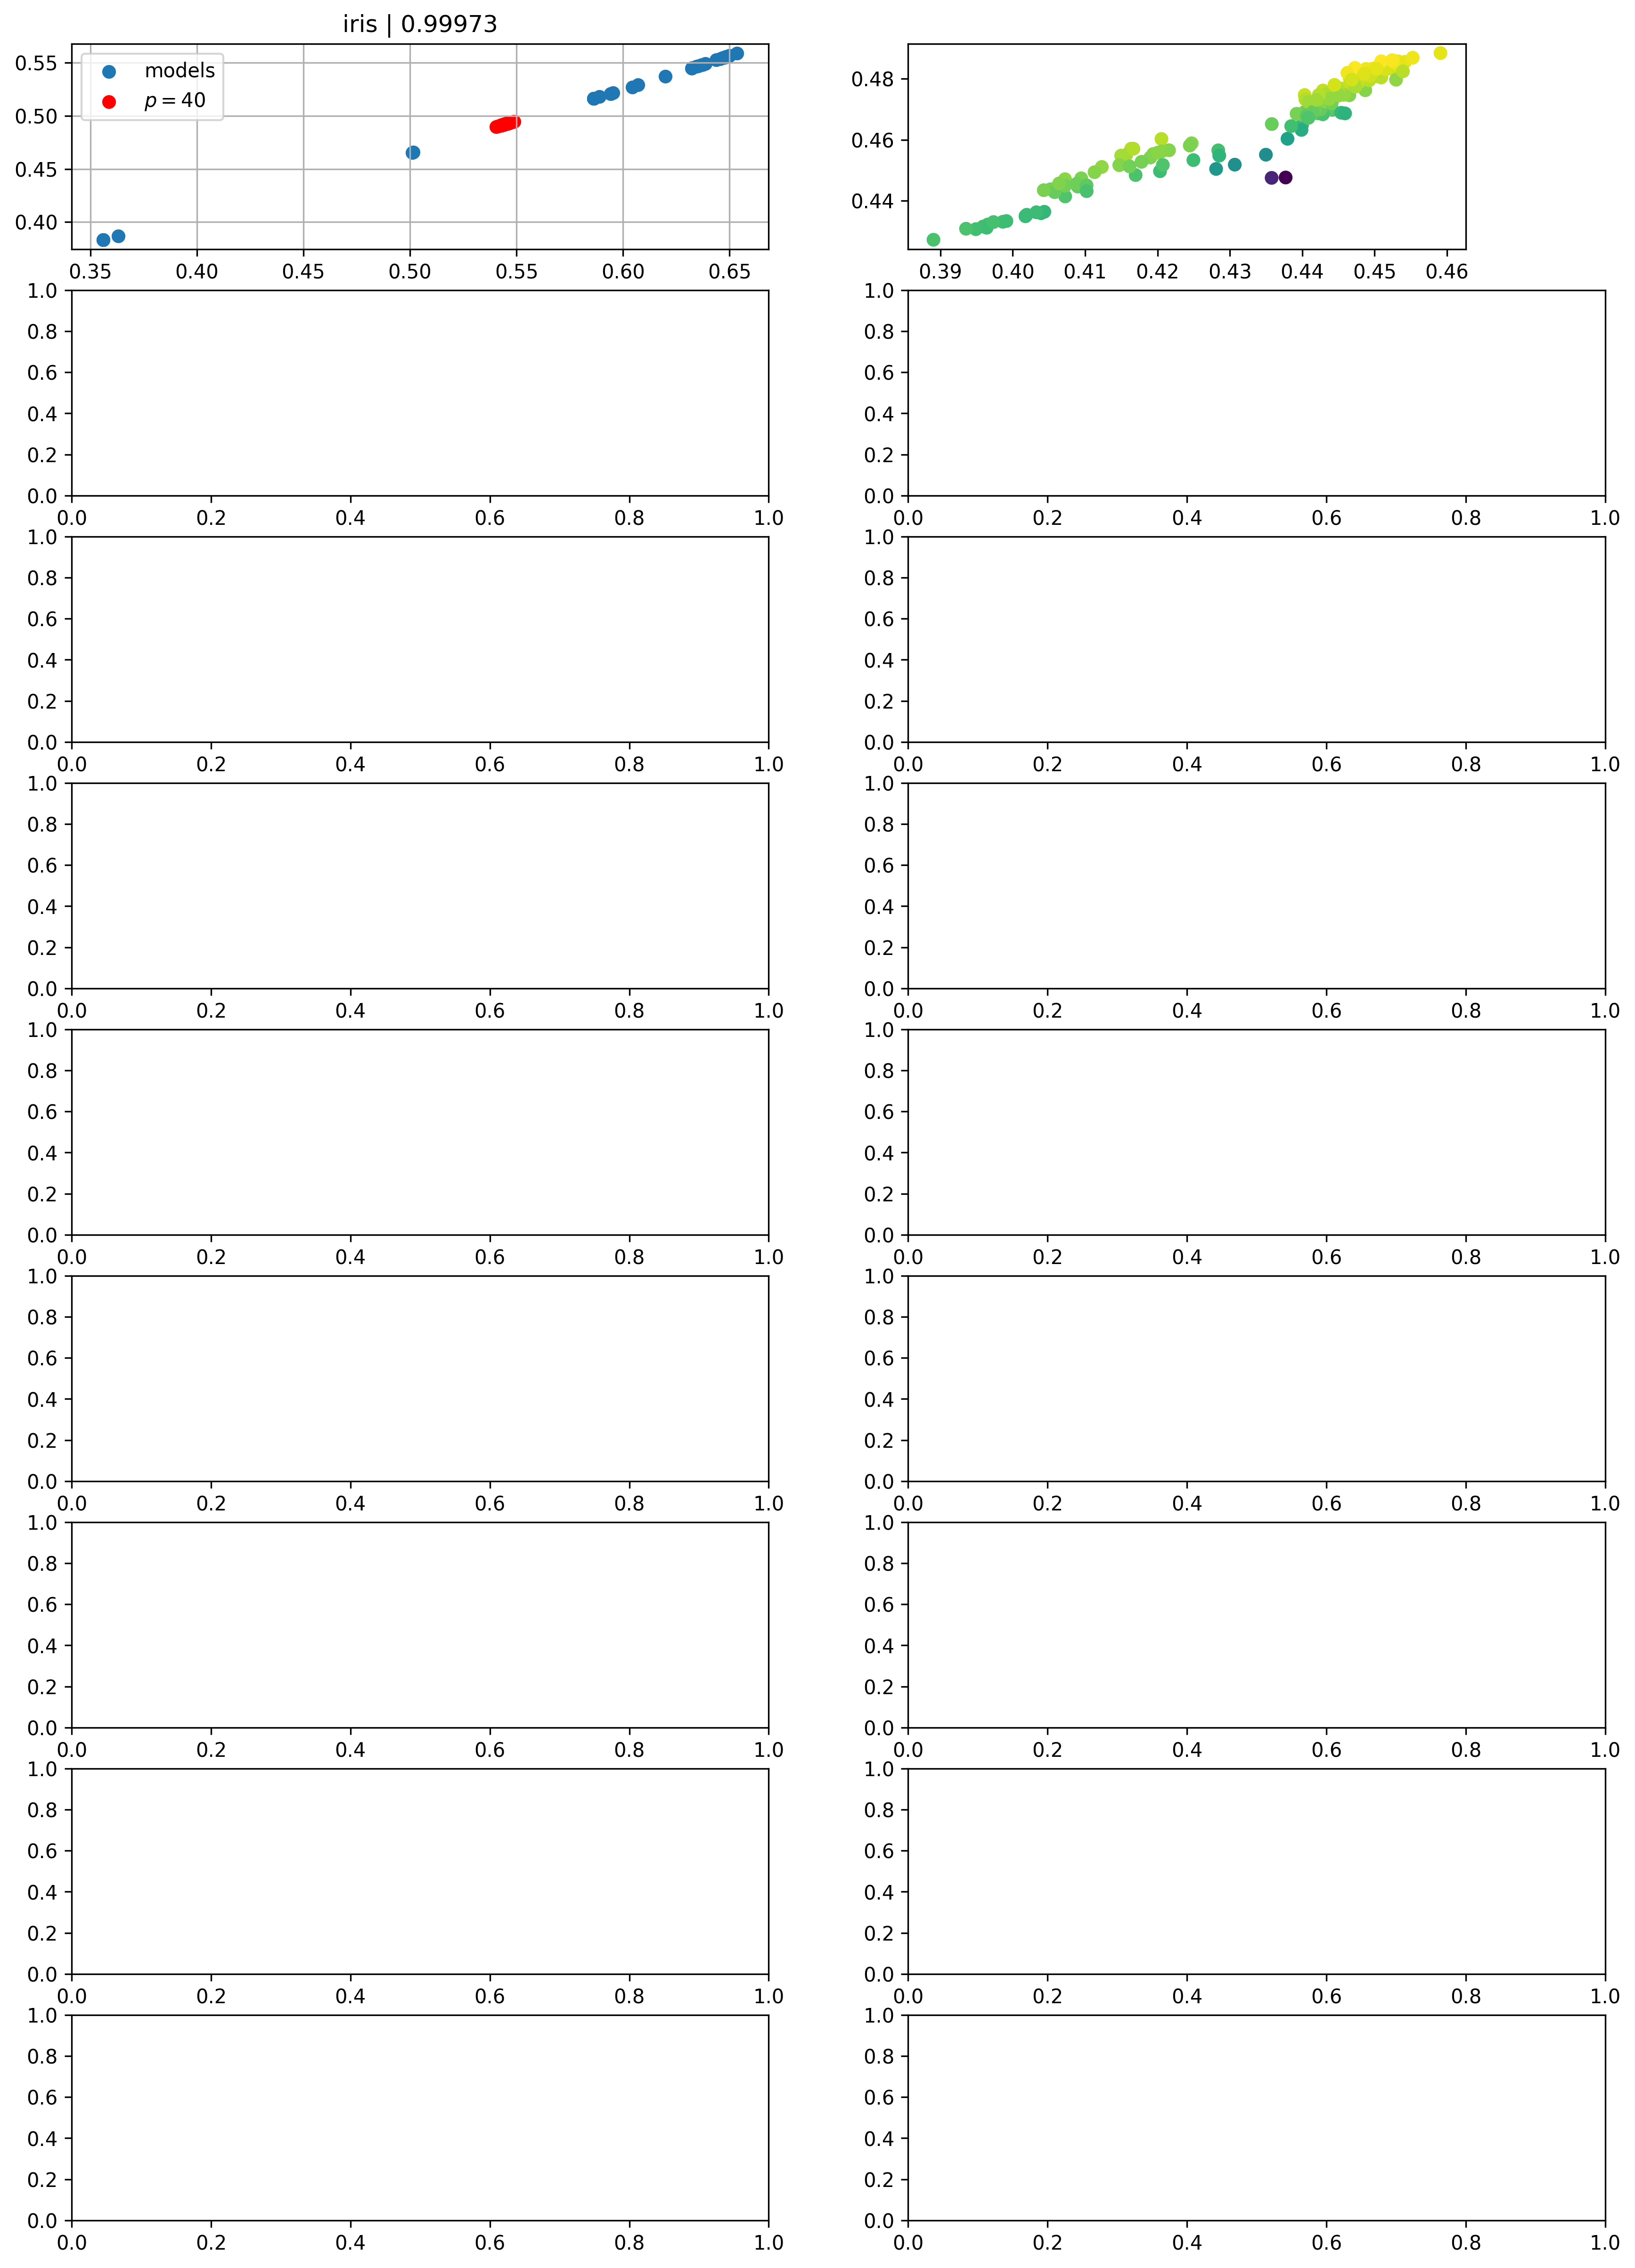

In [5]:
figs = {}
for i_random in tqdm(path_random):
    figs[i_random] = {}
    _fig, _axes = plt.subplots(len(config.file_names), 2, figsize=(14, 20), **parameters["outputs"]["args"])
    for idx, (i_name, i_content) in enumerate(list(data_pij[i_random].items())):
        pij_true = i_content["pij_true"].copy()
        abilities = data_params[i_random][i_name]["abilities"]
        diffs = data_params[i_random][i_name]["diff_disc"]
        response = (
            pij_true
            .T
            .mean(axis = 1)
            .to_frame("avg_response")
            .reset_index()
            .merge(abilities.reset_index(), on = ["index"])
        )
        response_models = (
            response[~response["index"].str.startswith("random_model_n")].copy()
        )
        response_random = (
            response[response["index"].str.startswith("random_model_n")].copy()
        )
        _params_plot = [
            {
                "x": _param[0],
                "y": _param[1],
            }
            for _param in [
                [response_models["avg_response"].values, response_models["abilities"].values],
                [1 - pij_true.mean(axis=1).values, diffs["difficulty"].values],
            ]
        ]

        for idx_param, _param in enumerate(_params_plot):
            if idx_param == 1:
                _param = _param | {"c": diffs["discrimination"].values}
                scatter = _axes[idx, idx_param].scatter(**_param)
                cbar = plt.colorbar(scatter, ax=_axes[idx, idx_param])
                cbar.set_label("discrimination")
            else:
                if i_random != "random_n0":
                    _param.update({"label": "models"})
                    
                scatter = _axes[idx, idx_param].scatter(**_param)

                if i_random != "random_n0":
                    _axes[idx, idx_param].scatter(
                            x = response_random["avg_response"].values,
                            y = response_random["abilities"].values,
                            c = "red",
                            label = r"$p = {}$".format(len(response_random["avg_response"].values))
                    )
                    _axes[idx, idx_param].legend()
            _axes[idx, idx_param].grid(True)
            _axes[idx, idx_param].set_title(
                i_name + " | {:.5}".format(np.corrcoef(_param["x"], _param["y"])[0, 1]), loc="center"
            )

        _axes[idx, 0].set_ylabel("abilities")
        _axes[idx, 1].set_ylabel("difficulty")

    _axes[-1, 0].set_xlabel("average_response")
    _axes[-1, 1].set_xlabel("1 - average_item")

    plt.tight_layout()
    plt.close()
    figs[i_random] = {
        "figure": _fig,
        "file_path": (path_outputs / Path("_".join([i_random, "abi", "diff", "versus"]) + ext_local_img)),
    }

## Unique plot

In [26]:
figs_unique = {}
xy_fontsize = 20
for i_random in tqdm(path_random[:1]):
    figs_unique[i_random] = {}
    for idx, (i_name, i_content) in enumerate(list(data_pij[i_random].items())):
        _fig_abi, _axes_abi = plt.subplots(1, 1, figsize=(10, 8), **parameters["outputs"]["args"])
        _fig_diff, _axes_diff = plt.subplots(1, 1, figsize=(10, 8), **parameters["outputs"]["args"])
        pij_true = i_content["pij_true"].copy()
        abilities = data_params[i_random][i_name]["abilities"]
        diffs = data_params[i_random][i_name]["diff_disc"]
        
        response = (
            pij_true
            .T
            .mean(axis = 1)
            .to_frame("avg_response")
            .reset_index()
            .merge(abilities.reset_index(), on = ["index"])
        )
        response_models = (
            response[~response["index"].str.startswith("random_model_n")].copy()
        )
        response_random = (
            response[response["index"].str.startswith("random_model_n")].copy()
        )
        _params_plot = [
            {
                "x": _param[0],
                "y": _param[1],
            }
            for _param in [
                [response_models["avg_response"].values, response_models["abilities"].values],
                [1 - pij_true.mean(axis=1).values, diffs["difficulty"].values],
            ]
        ]
        
        for idx_param, _param in enumerate(_params_plot):
            if idx_param == 1:
                # _param = _param | {"c": diffs["discrimination"].values}
                _axes_diff.set_xlabel(r"$1 - average\_item$", fontsize=xy_fontsize)
                _axes_diff.set_ylabel("$difficulties$", fontsize=xy_fontsize)
                scatter = _axes_diff.scatter(**_param)
                # cbar = plt.colorbar(scatter, ax=_axes_diff)
                # cbar.set_label("discrimination")
                
            else:
                _axes_abi.set_xlabel(r"$average\_response$", fontsize=xy_fontsize)
                _axes_abi.set_ylabel("$abilities$", fontsize=xy_fontsize)
                
                if i_random != "random_n0":
                    _param.update({"label": "models"})

                scatter = _axes_abi.scatter(**_param)
                if i_random != "random_n0":
                    _axes_abi.scatter(
                        x = response_random["avg_response"].values,
                        y = response_random["abilities"].values,
                        c = "red",
                        label = r"$p = {}$".format(len(response_random["avg_response"].values))
                    )
                    _axes_abi.legend()
            
            _axes_abi.grid(True)
            _axes_diff.grid(True)
            
            
            plt.close()
        _fig_abi.tight_layout()
        _fig_diff.tight_layout()
        figs_unique[i_random][i_name] = {
            "abilities": {
                "figure": _fig_abi,
                "file_path": (
                    path_outputs / Path("_".join([i_random, i_name, "abi", "versus"]) + ext_local_img)
                )
            },
            "difficulties": {
                "figure": _fig_diff,
                "file_path": (
                    path_outputs / Path("_".join([i_random, i_name, "diff", "versus"]) + ext_local_img)
                )
            }
        }
        del _axes_abi, _fig_abi
        del _axes_diff, _fig_diff

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


## Save

In [ ]:
for contents in tqdm(list(figs.values())):
    _fig, _file_path = contents["figure"], contents["file_path"]
    _fig.savefig(_file_path, **parameters["outputs"]["args"])

In [27]:
for i_random, i_content in tqdm(list(figs_unique.items())):
    for j_name, j_content in i_content.items():
        for which_param, contents in j_content.items():
            _fig, _file_path = contents["figure"], contents["file_path"]
            _fig.savefig(_file_path, **parameters["outputs"]["args"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]
